# Mobility in Tokyo

- Data source: NTT DoCoMo's [Mobile Kukan Toukei](https://mobaku.jp/)
    - “Mobile Kukan Toukei” is a trademark of NTT DOCOMO, INC.
    - NTT DOCOMO’s “Mobile Kukan Toukei” services are only available to subscribers in Japan.


In [4]:
# Load the row-based data and convert them into a table

import pandas as pd
import matplotlib.pyplot as plt
import os
%load_ext autotime

year = "2020"
year = "2019"

def convert_to_table(year):
    fn = "data/DoCoMo/" + year + "_all.csv"
    if os.path.exists(fn):
        pass
    else:
        d = pd.read_csv(fn,usecols=[0,1,2,6],names=["Date", "Time", "Mesh", "Population"],
                        # dtype={"Mesh":str},
                        parse_dates=[[0,1]],header=None)

        print("{} loaded, n_records={}".format(fn, len(d)))
        start_time, end_time = d["Date_Time"].min(), d["Date_Time"].max()
        time_range = pd.date_range(start=start_time, end=end_time, freq='H')
        print("time_range=", time_range)
        mesh_list = d["Mesh"].unique()
        print("n_mesh=", len(mesh_list))
        print("mesh_list=", mesh_list)
        df = pd.DataFrame(index=time_range, columns=mesh_list)

        for i, row in d.iterrows():
            if i % 100000 == 0:
                print("{}: Processing record {}...".format(pd.Timestamp.now(), i))
            date_time = row[0]
            mesh = row[1]
            population = row[2]
            df.loc[date_time, mesh] = population

        df.to_csv("Data/DoCoMo/" + year + "_out2.csv")

convert_to_table("2019")
convert_to_table("2020")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.39 ms


In [5]:
# Load table data into DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autotime
default_figsize = plt.rcParams['figure.figsize']

def read_out2(year):
    df = pd.read_csv("Data/DoCoMo/" + year + "_out2.csv", parse_dates=[0])
    df = df.rename(columns={'Unnamed: 0':"Date_Time"}).set_index("Date_Time").fillna(0)
    l1_delta = np.zeros(len(df))
    l2_delta = np.zeros(len(df))
    mean = np.zeros(len(df))
    std = np.zeros(len(df))
    for i in range(1,len(df)):
        l1_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=1)
        l2_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=2)
        mean[i] = df.iloc[i].mean()
        std[i] = df.iloc[i].std()
    df["L1"] = l1_delta
    df["L2"] = l2_delta
    df["mean"] = mean
    df["std"] = std
    return df

mobility_2019 = read_out2("2019")
mobility_2020 = read_out2("2020")



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3min 59s


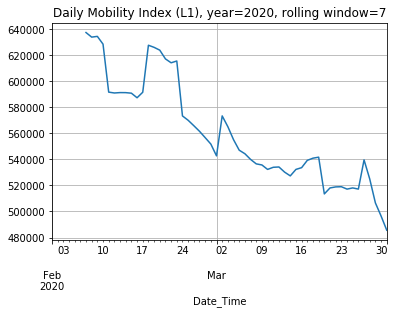

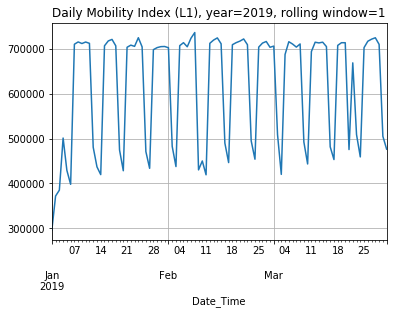

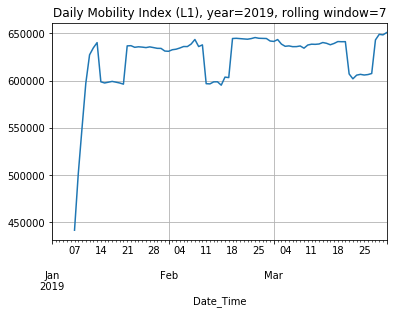

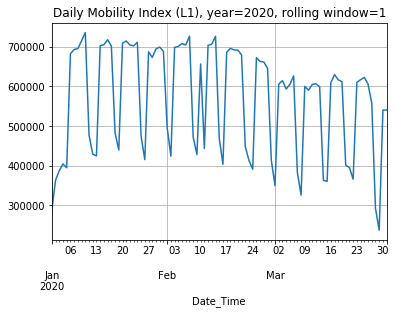

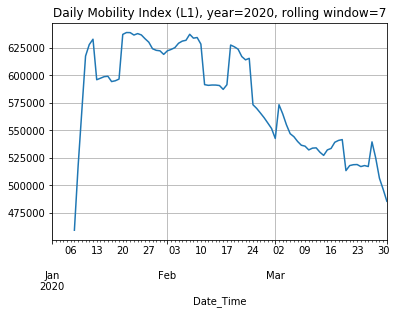

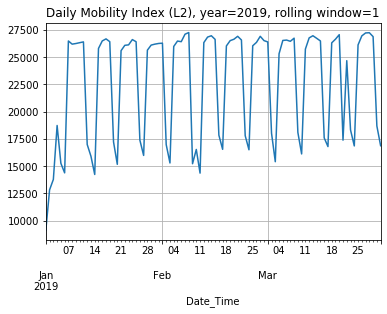

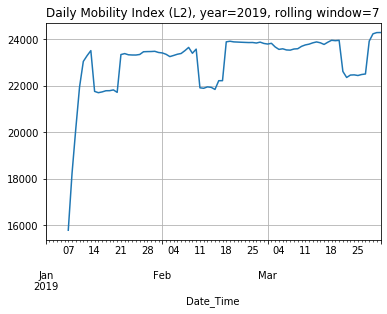

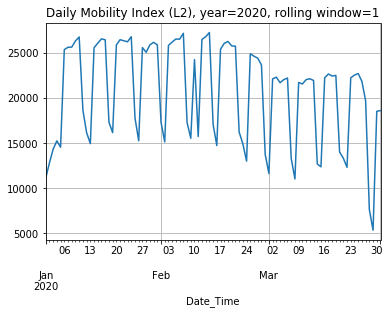

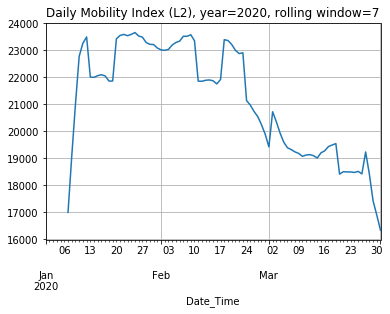

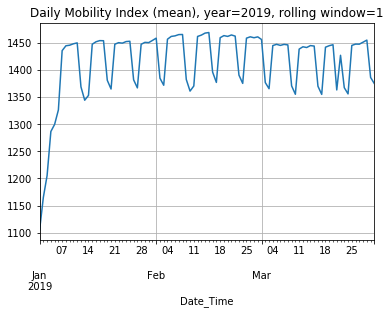

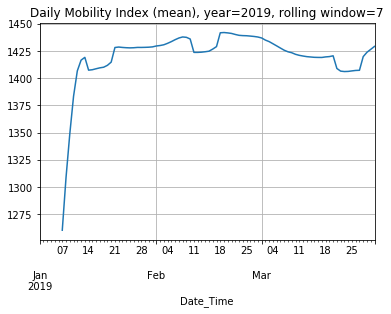

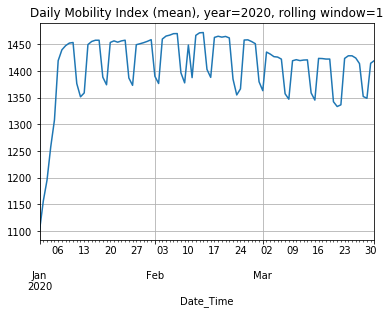

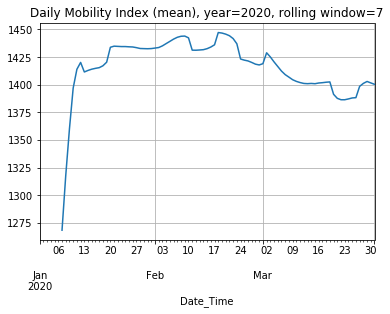

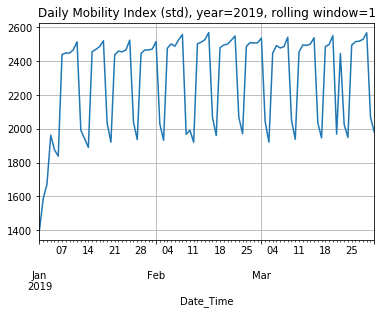

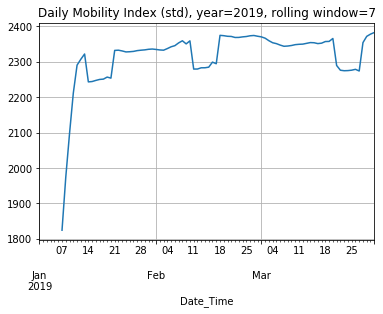

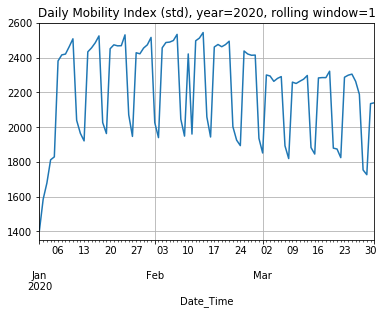

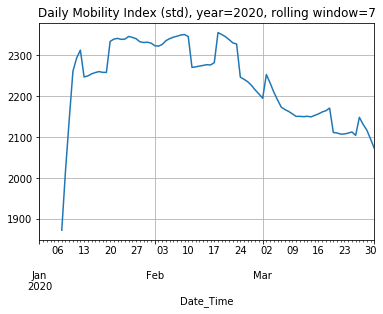

time: 8.02 s


In [6]:
# plot various mobility indicators 

def mobility_plot(df, metric, year, w):
    mobility = df[metric]
    daily_mobility = mobility.resample('1D').mean().rolling(w).mean()
    plt.title("Daily Mobility Index ({}), year={}, rolling window={}".format(metric, year,w))
    daily_mobility.plot(grid=True)
    plt.show()


mobility_plot(mobility_2020.loc[pd.to_datetime("2020-02-01"):], "L1", "2020", 7)
    
mobility_plot(mobility_2019, "L1", "2019", 1)
mobility_plot(mobility_2019, "L1", "2019", 7)
mobility_plot(mobility_2020, "L1", "2020", 1)
mobility_plot(mobility_2020, "L1", "2020", 7)

mobility_plot(mobility_2019, "L2", "2019", 1)
mobility_plot(mobility_2019, "L2", "2019", 7)
mobility_plot(mobility_2020, "L2", "2020", 1)
mobility_plot(mobility_2020, "L2", "2020", 7)

mobility_plot(mobility_2019, "mean", "2019", 1)
mobility_plot(mobility_2019, "mean", "2019", 7)
mobility_plot(mobility_2020, "mean", "2020", 1)
mobility_plot(mobility_2020, "mean", "2020", 7)

mobility_plot(mobility_2019, "std", "2019", 1)
mobility_plot(mobility_2019, "std", "2019", 7)
mobility_plot(mobility_2020, "std", "2020", 1)
mobility_plot(mobility_2020, "std", "2020", 7)



## Confirmed Cases in Tokyo
- Data source: [Tokyo Metropolitan Governmnet Open Data Catalogue Site](https://portal.data.metro.tokyo.lg.jp/) [Dashboard](https://stopcovid19.metro.tokyo.lg.jp/)

Days in daily_confirmed_cases= 43


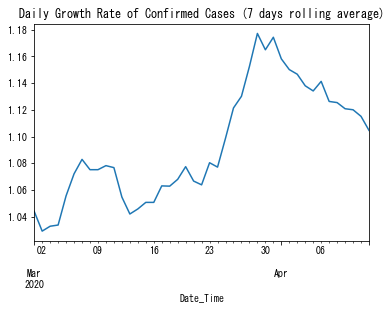

time: 1.41 s


In [7]:
# Load confirmed cases

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

daily_confirmed_cases = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv',
                    usecols=["公表_年月日", "患者_年代", "患者_性別"],
                    parse_dates=["公表_年月日"]) \
    .groupby("公表_年月日") \
    .count().drop(columns=["患者_年代"]) \
    .reset_index() \
    .rename(columns={"患者_性別": "Confirmed_Cases", "公表_年月日": "Date_Time"}) \
    .set_index("Date_Time")

daily_confirmed_cases = daily_confirmed_cases.asfreq('1D', fill_value=0)

# display(daily_confirmed_cases.asfreq('1D', fill_value=0))

window = 7
# plt.grid()
daily_confirmed_cases["Cumulative"] = daily_confirmed_cases["Confirmed_Cases"].cumsum()
daily_confirmed_cases["GrowthRate"] = daily_confirmed_cases["Cumulative"].pct_change().rolling(window).mean()
daily_confirmed_cases = daily_confirmed_cases["2020-03-01":]
days = len(daily_confirmed_cases)
print("Days in daily_confirmed_cases=", len(daily_confirmed_cases))

plt.title("Daily Growth Rate of Confirmed Cases ({} days rolling average)".format(window)) 
(daily_confirmed_cases["GrowthRate"] + 1.0).plot()

last date in mobility = 2020-03-31 00:00:00
last date confirmed = 2020-04-12 00:00:00
first date confirmed = 2020-03-01 00:00:00
min_delay =  12
days in confirmed_cases = 42 days 00:00:00
12 2020-02-18 00:00:00 2020-03-31 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


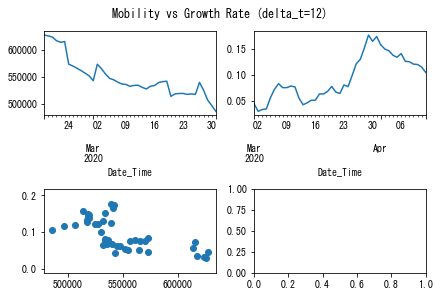

13 2020-02-17 00:00:00 2020-03-30 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


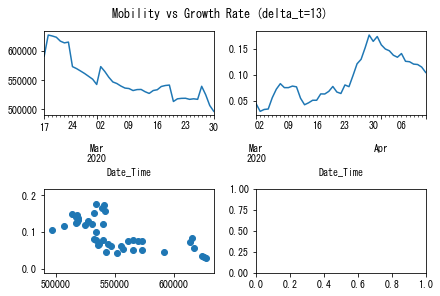

14 2020-02-16 00:00:00 2020-03-29 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


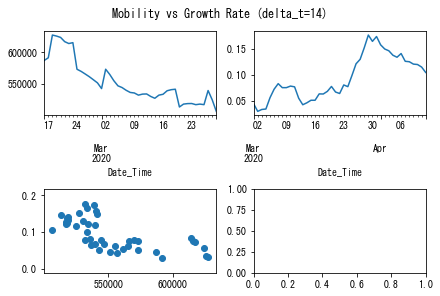

15 2020-02-15 00:00:00 2020-03-28 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


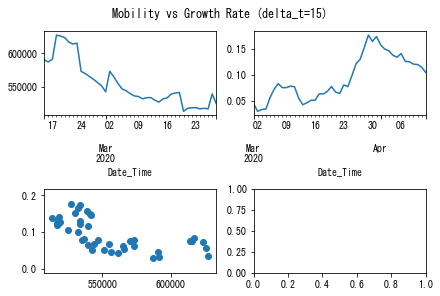

16 2020-02-14 00:00:00 2020-03-27 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


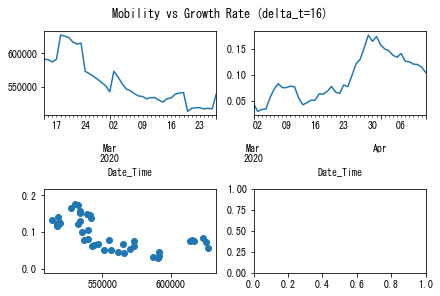

17 2020-02-13 00:00:00 2020-03-26 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


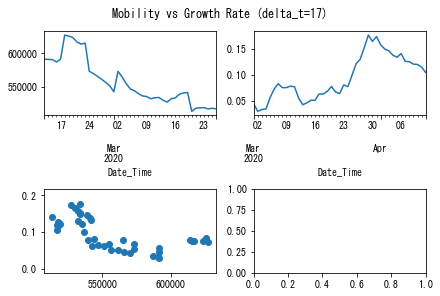

18 2020-02-12 00:00:00 2020-03-25 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


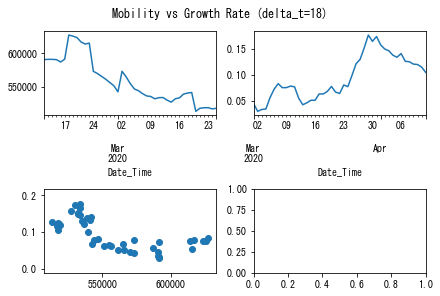

19 2020-02-11 00:00:00 2020-03-24 00:00:00 2020-03-01 00:00:00 2020-04-12 00:00:00 (43,) (43,)


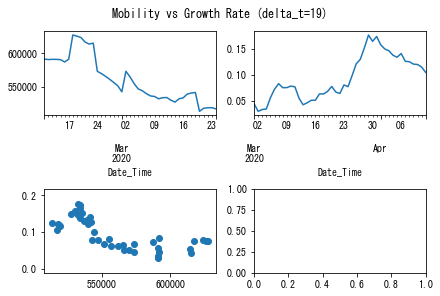

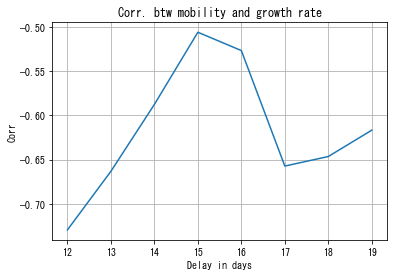

time: 7.44 s


In [8]:
# Caculate correlations between mobility and growth rate of confirmed cases

import datetime 

daily_mobility = mobility_2020.resample('1D').mean().rolling(7).mean()
# display(daily_confirmed_cases)

last_date_mobility = daily_mobility.index[-1]
last_date_confirmed = daily_confirmed_cases.index[-1]
first_date_confirmed = daily_confirmed_cases.index[0]
min_delay = last_date_confirmed - last_date_mobility
days_in_confirmed_cases = last_date_confirmed - first_date_confirmed
print("last date in mobility =",last_date_mobility)
print("last date confirmed =", last_date_confirmed )
print("first date confirmed =", first_date_confirmed )
print("min_delay = ", min_delay.days)
print("days in confirmed_cases =", days_in_confirmed_cases)

w = 20 # max delta t
corr = np.zeros(w)
for delta_t in range(min_delay.days, w):
    s0 = first_date_confirmed - datetime.timedelta(days=delta_t)
    e0 = s0 + days_in_confirmed_cases
    m = daily_mobility["L1"][s0:e0]
    s1 = s0 + datetime.timedelta(days=delta_t)
    e1 = e0 + datetime.timedelta(days=delta_t)
    g = daily_confirmed_cases["GrowthRate"][s1:e1]
    print(delta_t, s0, e0, s1, e1, m.shape, g.shape)
    corr[delta_t] = m.corr(g)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle("Mobility vs Growth Rate (delta_t={})".format(delta_t))
    m.plot(ax=axs[0, 0])
    g.plot(ax=axs[0, 1])
    axs[1, 0].scatter(m, g)
    plt.show()
    # print(d, len(n_calls), len(n_reported), corr[d])

plt.grid()
plt.title("Corr. btw mobility and growth rate")
plt.xlabel("Delay in days")
plt.ylabel("Corr")
plt.plot(np.array(range(min_delay.days, w)), corr[min_delay.days:w])

(12,) (6,)


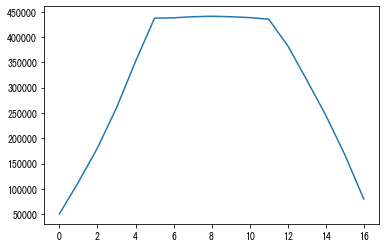

time: 556 ms


In [9]:
import sklearn
m = daily_mobility["L1"]["2020-03-20":"2020-03-31"]
g = daily_confirmed_cases["GrowthRate"]["2020-03-25":"2020-03-30"]
print(m.shape, g.shape)
plt.plot(np.convolve(g, m))

# Statistics on Mobility Data


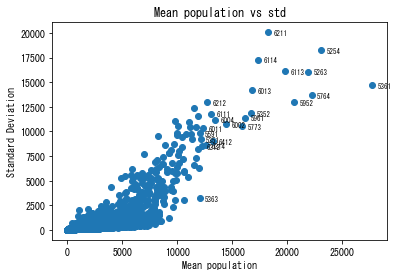

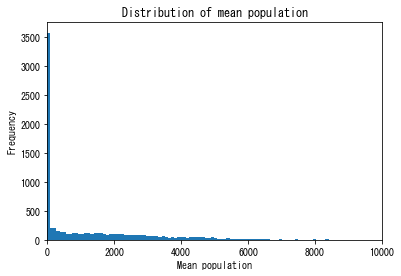

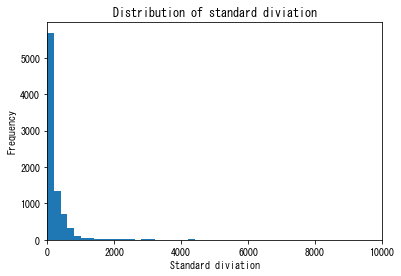

Large mean grids
533945361    27699.655220
533945254    23069.033883
533945764    22222.128663
533945263    21900.324176
533935952    20636.413004
533946113    19846.198260
533946211    18296.348901
533946114    17337.473443
533946013    16769.160714
533945352    16680.184982
533935961    16184.550366
533945773    15869.383700
533946002    14434.070055
533946004    13412.410256
533946412    13283.095238
533946111    13042.387821
533946212    12698.740842
533946314    12652.120879
533946011    12351.217033
533946312    12213.036172
533945351    12114.509158
533935591    12037.576465
533945363    12033.850275
533935764    11969.782051
533935863    11922.036630
533946001    11910.893773
533935854    11735.281136
533946214    11704.194597
533945771    11530.186355
533946213    11524.754579
533936903    11356.394689
533945253    11288.539835
533945093    11136.196429
533946112    11046.670788
533943333    10972.245879
533935593    10751.473443
533945362    10618.280220
533945762    10603.53

Index(['533935591', '533935952', '533935961', '533945254', '533945263',
       '533945351', '533945352', '533945361', '533945363', '533945764',
       '533945773', '533946002', '533946004', '533946011', '533946013',
       '533946111', '533946113', '533946114', '533946211', '533946212',
       '533946312', '533946314', '533946412'],
      dtype='object')

time: 1.68 s


In [10]:
mean = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).std()



plt.title("Mean population vs std")
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std)
large_mean = mean[mean>12000]
for mesh in large_mean.index:
    plt.text(mean[mesh]+500, std[mesh]-300, str(mesh)[-4:], fontsize=7 )

plt.show()

plt.title("Distribution of mean population")
plt.xlabel("Mean population")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(mean, bins=300)
# plt.plot(mean.cumsum())
plt.show()

plt.title("Distribution of standard diviation")
plt.xlabel("Standard diviation")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(std, bins=100)
plt.show()

mobility_2020
print("Large mean grids")
print(mean[mean>10000].sort_values(ascending=False))
print("Large std grids")
print(std[std>15000].sort_values(ascending=False))

large_mean.index

- 平均人口が最も多いのは歌舞伎町 The largest mean populatioin is at Kabuki-cho (533945361    27699.655220)
- 標準偏差が最も大きいのは大手町 The largest standard diviation is at Otemachi（533946211    20066.947698）

You can check the location of a meshcode at [Geocode Viewer](http://www.geosense.co.jp/map/tool/geoconverter.php) 

まあ、そうだろう、という感じ The results are no surprise.

533945361 歌舞伎町 27699.65521978022 14719.962511456983
533946211 大手町 18296.3489010989 20066.94769826584
533934771 成城学園前 1604.0929487179487 224.24352409733558
533935431 八雲 3806.7509157509157 602.8424906083677


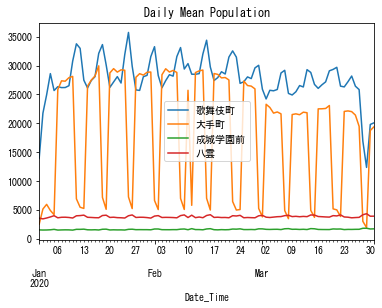

time: 383 ms


In [11]:
# Plot daily mean population for selected grid cells

focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
to_plot = mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .resample('1D').mean()

to_plot .plot()
plt.title("Daily Mean Population")
to_plot.std()
for key in focused_grids:
    print(key,focused_grids[key], mean[key], std[key] )


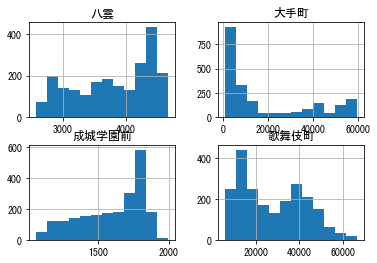

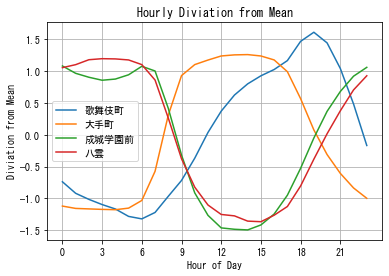

Index(['歌舞伎町', '大手町', '成城学園前', '八雲'], dtype='object')

time: 812 ms


In [12]:
# Other statistics for selected grid cells

from sklearn import preprocessing

focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
# focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
# 歌舞伎町と大手町の人口ヒストグラム
mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .hist(bins=12)
plt.show()

hour_of_day = mobility_2020.groupby(mobility_2020.index.hour).mean()
hour_of_day = hour_of_day[list(focused_grids.keys())] \
    .rename(columns=focused_grids)


h = preprocessing.scale(hour_of_day)
for i in range(len(hour_of_day.columns)):
    plt.plot(range(24),h[:, i],label=hour_of_day.columns[i])
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 24, step=3))
plt.title("Hourly Diviation from Mean")
plt.xlabel("Hour of Day")
plt.ylabel("Diviation from Mean")
plt.show()
hour_of_day.columns

## Correlation with onset dates

- Data source:  [Jag Japan](https://gis.jag-japan.com/covid19jp/)

Unfortunately the data has no onset date for recent Tokyo cases.

last_date= 2020-04-12 00:00:00 n_records= 9119
2068


受診都道府県    217
dtype: int64

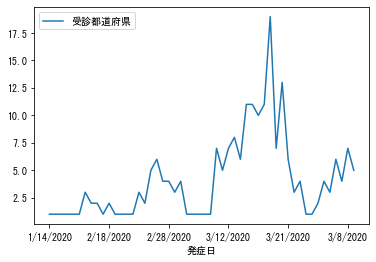

time: 1.86 s


In [10]:
# Correlation with onset dates

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)
fn = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
# fn = 'data/JAG_Japan/COVID-19.csv'

def read_data():
    d = pd.read_csv(fn,usecols=["確定日", "発症日", "受診都道府県"],parse_dates=["確定日", "発症日"])
    d = d.drop(["不明", "中部国際空港", "成田空港", "羽田空港", "関西国際空港"], errors='ignore')
    return d


jag_report = read_data()
last_date = jag_report["確定日"].max()
print("last_date=", last_date, "n_records=", len(jag_report))
jag_report = jag_report.drop(columns=["確定日"])
print(len(jag_report[jag_report["受診都道府県"]=="東京都"]))
onset = jag_report[jag_report["受診都道府県"]=="東京都"].groupby("発症日").count()
onset.plot()
onset.sum()

発症日のデータを取ってみたが、東京都の症例では、最近は発症日が記入されていない。このため、よい相関が取れない。あきらめ。


In [11]:
# Experimantal code. Please ignore
if 0: 

    fig, ax1 = plt.subplots()

    # ヒストグラムプロットとビン情報の取得
    n, bins, patches = ax1.hist(mean, alpha=0.7, label='Frequency', bins=20)
    ax1.grid(axis='x')
    ax1.set_xlabel("Grid Population")
    ax1.set_ylabel("Frequency")

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax1.twinx()
    lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
             label='Cumulative ratio')
    ax2.grid(visible=True)
    ax2.set_ylabel("Cumulative %")

    plt.show()

time: 999 µs


In [12]:
# Experimantal code. Please ignore

if 0: 
    ranked_means = mean.sort_values(ascending=False)
    # print(ranked_means)
    total = ranked_means.sum()
    print("sum=", total)
    top_n = 100

    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(top_n), ranked_means[:top_n])
    ax2 = ax1.twinx()
    ax2.plot(ranked_means[:top_n].cumsum() / total)
    plt.show()

time: 7 ms


In [13]:
# Experimantal code. Please ignore

if 0: 
    # 平成25年住宅・土地統計調査 確報集計
    print(pd.__version__)
    fn = 'data/estat/FEH_00200522_200408215652.csv'

    def read_data():
        d = pd.read_csv(fn, skiprows=14, sep=',', usecols=["H25地域", "世帯の年間収入階級_2013", "総数" ], 
                        thousands=',', encoding="SHIFT-JIS")
        d["総数"] = d["総数"].str.replace(',', '')
        d["総数"] = d["総数"].str.replace('-', '0')  #  '-' はゼロと解釈
        d["総数"] = d["総数"].astype(int)
        return d

    rank = [0, 100, 200, 300, 400, 500, 700, 1000, 1500]
    # rank = [50, 150, 250, 350, 450, 600, 850, 1250, 1500]

    def median(total, counts):
        # print("total=", total, "counts=", counts)
        h = total / 2
        c = 0
        for i in range(len(counts)):
            c += counts.values[i]
            if c > h:
                return rank[i]
        return None

    household_income = read_data()
    # print(household_income["総数"])
    n_records = len(household_income)
    meds = np.zeros(n_records)
    for i in range(0, n_records, 10):
    # for i in range(0, 1, 10):
        # print(household_income.iloc[i]["H25地域"])
        m = median(household_income.iloc[i]["総数"], household_income.iloc[i+1:i+10]["総数"])
        meds[i] = m

    household_income["Median"] = meds

    household_income


time: 5 ms


## Research Question: Which areas show larger mobility changes due to COVID-19?

1. Cluster grid cells
- Define mobility reduction
    - Take two time points, $t_1$ and $t_2$, and compute the mobility difference $\Delta = d(m(t_1), m(t_2))$
    - Let's take three Tuesdays, $t_0=$ Feb 4 (before Diamond Princess), $t_1$ = Mar 3 (after school closure), and $t_2=$ Mar 31 (lockdown imminent).
    - Calculate $\Delta = d(m(t_0), m(t_1))$ and $\Delta = d(m(t_0), m(t_2))$ for every cell

Using saved cluster data/DoCoMo/cluster.txt


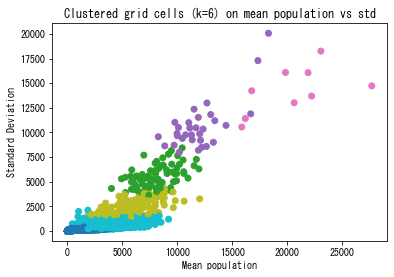

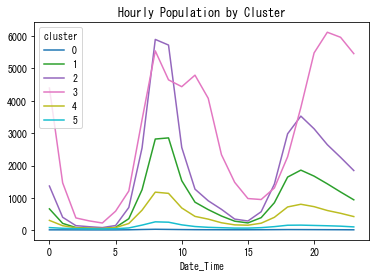

time: 1.72 s


In [13]:
# Cluster grid cells

from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
import os

mobility_2020_L1 = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()
mobility_2020_L1_daily = mobility_2020_L1.groupby(mobility_2020_L1.index.hour).mean()

# If already clustered, use them
n_clusters = 6
cluster_fn = 'data/DoCoMo/cluster.txt'
if os.path.exists(cluster_fn):
    pred = np.loadtxt(cluster_fn)
    print('Using saved cluster', cluster_fn)
else:
    pred = KMeans(n_clusters=n_clusters).fit_predict(mobility_2020_L1_daily.values.T)
    np.savetxt('data/DoCoMo/cluster.txt',pred)


mean = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).std()

cmap = plt.get_cmap("tab10")

# Scatter Plot between mean and std
plt.title("Clustered grid cells (k={}) on mean population vs std".format(n_clusters))
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std, c=pred, cmap=cmap)
mobility_2020_L1_daily_t = mobility_2020_L1_daily.T
mobility_2020_L1_daily_t["cluster"] = pred.astype(int)

# Hourly population by Cluster
title = "Hourly Population by Cluster"
mobility_2020_L1_daily_t.groupby("cluster").mean().T.plot(title=title, cmap=cmap)
plt.show()

clustered_cells = mobility_2020_L1_daily_t["cluster"]
clustered_cells_df = pd.DataFrame(clustered_cells).reset_index().rename(columns={"index": "meshcode"})


## Plot results on map
- This code is by Kunihiko Miyoshi (https://github.com/colspan)

- Data source: 
    - 国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
    - 国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html
    - GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson

In [2]:
# This code is by Kunihiko Miyoshi (https://github.com/colspan)
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

%matplotlib inline
%load_ext autotime

pref_name_def = {
    "01": {
        "name_jp": "北海道",
        "name_en": "Hokkaido"
    },
    "02": {
        "name_jp": "青森県",
        "name_en": "Aomori"
    },
    "03": {
        "name_jp": "岩手県",
        "name_en": "Iwate"
    },
    "04": {
        "name_jp": "宮城県",
        "name_en": "Miyagi"
    },
    "05": {
        "name_jp": "秋田県",
        "name_en": "Akita"
    },
    "06": {
        "name_jp": "山形県",
        "name_en": "Yamagata"
    },
    "07": {
        "name_jp": "福島県",
        "name_en": "Fukushima"
    },
    "08": {
        "name_jp": "茨城県",
        "name_en": "Ibaraki"
    },
    "09": {
        "name_jp": "栃木県",
        "name_en": "Tochigi"
    },
    "10": {
        "name_jp": "群馬県",
        "name_en": "Gunma"
    },
    "11": {
        "name_jp": "埼玉県",
        "name_en": "Saitama"
    },
    "12": {
        "name_jp": "千葉県",
        "name_en": "Chiba"
    },
    "13": {
        "name_jp": "東京都",
        "name_en": "Tokyo"
    },
    "14": {
        "name_jp": "神奈川県",
        "name_en": "Kanagawa"
    },
    "15": {
        "name_jp": "新潟県",
        "name_en": "Niigata"
    },
    "16": {
        "name_jp": "富山県",
        "name_en": "Toyama"
    },
    "17": {
        "name_jp": "石川県",
        "name_en": "Ishikawa"
    },
    "18": {
        "name_jp": "福井県",
        "name_en": "Fukui"
    },
    "19": {
        "name_jp": "山梨県",
        "name_en": "Yamanashi"
    },
    "20": {
        "name_jp": "長野県",
        "name_en": "Nagano"
    },
    "21": {
        "name_jp": "岐阜県",
        "name_en": "Gifu"
    },
    "22": {
        "name_jp": "静岡県",
        "name_en": "Shizuoka"
    },
    "23": {
        "name_jp": "愛知県",
        "name_en": "Aichi"
    },
    "24": {
        "name_jp": "三重県",
        "name_en": "Mie"
    },
    "25": {
        "name_jp": "滋賀県",
        "name_en": "Shiga"
    },
    "26": {
        "name_jp": "京都府",
        "name_en": "Kyoto"
    },
    "27": {
        "name_jp": "大阪府",
        "name_en": "Osaka"
    },
    "28": {
        "name_jp": "兵庫県",
        "name_en": "Hyogo"
    },
    "29": {
        "name_jp": "奈良県",
        "name_en": "Nara"
    },
    "30": {
        "name_jp": "和歌山県",
        "name_en": "Wakayama"
    },
    "31": {
        "name_jp": "鳥取県",
        "name_en": "Tottori"
    },
    "32": {
        "name_jp": "島根県",
        "name_en": "Shimane"
    },
    "33": {
        "name_jp": "岡山県",
        "name_en": "Okayama"
    },
    "34": {
        "name_jp": "広島県",
        "name_en": "Hiroshima"
    },
    "35": {
        "name_jp": "山口県",
        "name_en": "Yamaguchi"
    },
    "36": {
        "name_jp": "徳島県",
        "name_en": "Tokushima"
    },
    "37": {
        "name_jp": "香川県",
        "name_en": "Kagawa"
    },
    "38": {
        "name_jp": "愛媛県",
        "name_en": "Ehime"
    },
    "39": {
        "name_jp": "高知県",
        "name_en": "Kochi"
    },
    "40": {
        "name_jp": "福岡県",
        "name_en": "Fukuoka"
    },
    "41": {
        "name_jp": "佐賀県",
        "name_en": "Saga"
    },
    "42": {
        "name_jp": "長崎県",
        "name_en": "Nagasaki"
    },
    "43": {
        "name_jp": "熊本県",
        "name_en": "Kumamoto"
    },
    "44": {
        "name_jp": "大分県",
        "name_en": "Oita"
    },
    "45": {
        "name_jp": "宮崎県",
        "name_en": "Miyazaki"
    },
    "46": {
        "name_jp": "鹿児島県",
        "name_en": "Kagoshima"
    },
    "47": {
        "name_jp": "沖縄県",
        "name_en": "Okinawa"
    },
}

# define functions

def meshcode_to_latlng(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = float((int(meshcode[8])-1) // 2) * 1.0/8.0/10.0/2.0/1.5
        half_lon = float((int(meshcode[8])-1) % 2) * 1.0/8.0/10.0/2.0
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = float(meshcode[0:2])/1.5 + float(meshcode[4]) * \
        1.0/8.0/1.5 + float(meshcode[6])*1.0/8.0/10.0/1.5 + half_lat
    longtitude = float(meshcode[2:4])+100.0 + float(meshcode[5]) * \
        1.0/8.0 + float(meshcode[7])*1.0/8.0/10.0 + half_lon
    return (latitude, longtitude)


def meshcode_to_latlng_index(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = (int(meshcode[8])-1) // 2
        half_lon = (int(meshcode[8])-1) % 2
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = int(meshcode[0:2])*8*10*2 + int(meshcode[4]
                                               )*10*2 + int(meshcode[6])*2 + half_lat
    longtitude = int(meshcode[2:4])*8*10*2 + \
        int(meshcode[5])*10*2 + int(meshcode[7])*2 + half_lon
    return (latitude, longtitude)

def llindex_to_latlng(lli):
    return (
        float(lli[0]) / 2 / 8 / 10 / 1.5,
        float(lli[1]) / 2 / 8 / 10 + 100)

def meshcode_to_polygon(meshcode):
    south_west_i = meshcode_to_latlng_index(meshcode)

    lat_i, lon_i = south_west_i
    diff = 1 if len(meshcode) == 9 else 2
    north_east_i = (lat_i + diff, lon_i + diff)
    sw_geo = llindex_to_latlng(south_west_i)
    ne_geo = llindex_to_latlng(north_east_i)

    coordinates = [
        [sw_geo[1], sw_geo[0]],
        [sw_geo[1], ne_geo[0]],
        [ne_geo[1], ne_geo[0]],
        [ne_geo[1], sw_geo[0]],
        [ne_geo[1], sw_geo[0]]
    ]
    return coordinates

df_tokyo = gpd.read_file('data/JapanCityGeoJason/13_tokyo.json')
# 重複を除外する
df_tokyo = df_tokyo[df_tokyo['id']!='13']
# 諸島を除外する
df_tokyo = df_tokyo[df_tokyo['id'].apply(lambda x: int(x)<13361)]

# 注意 : このデータを利用するには下記クレジットが必要
'''
国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html

GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson
'''
# 地図を描画
ax = df_tokyo.boundary.plot(color='blue')



ModuleNotFoundError: No module named 'geopandas'

time: 100 ms


In [ ]:
from shapely.geometry import Polygon
# figsize_save = plt.rcParams['figure.figsize']
def show_cells_on_map(df, column, cmap=cmap, title=None, legend=False, legend_kwds=None):
    # df should have "meshcode" for meshcode and column for the data to be displayed
    plt.rcParams['figure.figsize'] = (20, 10)
    # 島しょ部を除外する
    df_poplog_geo = df[df.meshcode > '530000000']
    df_poplog_geo = gpd.GeoDataFrame(df_poplog_geo)

    # meshcodeに対応するポリゴンを生成する
    df_poplog_geo['geometry'] = df_poplog_geo['meshcode'].apply(lambda x: Polygon(meshcode_to_polygon(x)))  

    ax = df_poplog_geo.plot(column=column, cmap=cmap, legend=legend, legend_kwds=legend_kwds)
    plt.title(title)
    plt.rcParams['figure.figsize'] = default_figsize
    
show_cells_on_map(clustered_cells_df, 'cluster', title="Cluster")

NameError: name 'show_cells_on_map' is not defined

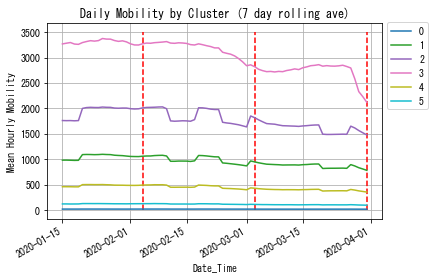

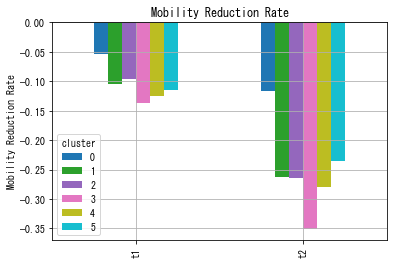

time: 988 ms


In [14]:
# Mobility Time Series by Cluster
window = 7
mobility_by_cells = mobility_2020_L1.resample('1D').mean().rolling(window).mean().loc['2020-1-15':].T
m = mobility_by_cells.copy()
m["cluster"] = pred.astype(int)
title = "Daily Mobility by Cluster ({} day rolling ave)".format(window)
mobility_by_cluster = m.groupby("cluster").mean().T
mobility_by_cluster.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.ylabel("Mean Hourly Mobility")
plt.vlines(['2020-02-04', '2020-03-03', '2020-03-31'], 0, 3500, "red", linestyles='dashed')

# mobility reduction rate by cluster
m = mobility_by_cluster.T.loc[:,pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31'])]
m["t1"] = m[pd.to_datetime('2020-03-03')] / m[pd.to_datetime('2020-02-04')] - 1.0
m["t2"] = m[pd.to_datetime('2020-03-31')] / m[pd.to_datetime('2020-02-04')] - 1.0
m[["t1", "t2"]].T.plot.bar(cmap=cmap, grid=True)
plt.title("Mobility Reduction Rate")
plt.ylabel("Mobility Reduction Rate")

# mobility reduction by cells
m = mobility_by_cells
reduction_by_cells = pd.DataFrame([ - m[pd.to_datetime('2020-03-03')] + m[pd.to_datetime('2020-02-04')],
                                       - m[pd.to_datetime('2020-03-31')] + m[pd.to_datetime('2020-02-04')]]).T
# reduction_by_cells.T.loc["533945361"]  # 歌舞伎町
reduction_by_cells = reduction_by_cells.reset_index().rename(columns={"index":"meshcode", 0:"t1", 1:"t2"})
reduction_by_cells['t1'] = reduction_by_cells['t1'].replace([np.inf, -np.inf], np.nan)
reduction_by_cells['t2'] = reduction_by_cells['t2'].replace([np.inf, -np.inf], np.nan)
reduction_by_cells = reduction_by_cells.fillna(0)
show_cells_on_map(reduction_by_cells, 't2', title="Mobility Reduction by Grid",
                  legend_kwds={'label': "Reduction (absolute numbers) from Feb.4 to Mar. 31", 'orientation': "horizontal"},
                  cmap='OrRd', legend=True)
print(reduction_by_cells.describe())
reduction_by_cells.to_csv("Data/DoCoMo/mobility_reduction_by_cells.csv")


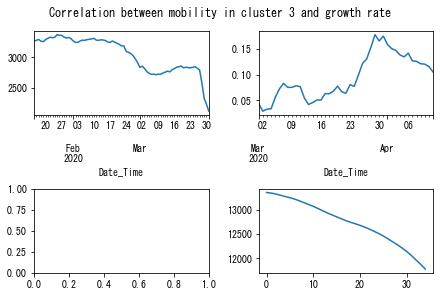

time: 896 ms


In [15]:
cluster = 3
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle("Correlation between mobility in cluster {} and growth rate".format(cluster))
m = mobility_by_cluster.loc[:,cluster]
m.plot(ax=axs[0, 0])
c = daily_confirmed_cases["GrowthRate"]
c.plot(ax=axs[0, 1])
# axs[1,0].plot(c)
axs[1,1].plot(np.convolve(m, c, mode='valid'))
# daily_confirmed_cases